In [ ]:
!wget https://vub-my.sharepoint.com/:u:/g/personal/giannis_bekoulis_vub_be/ETUgphHCacpOk8nMx5JUSz0BF72pdact8-CTHwgVWLfVsQ?download=1
!mv ETUgphHCacpOk8nMx5JUSz0BF72pdact8-CTHwgVWLfVsQ?download=1 data.zip
!unzip data.zip #img_aligen_celeba small

##Uncommment the following lines in the case that you would like to run your model on the full dataset 
#!wget https://vub-my.sharepoint.com/:u:/g/personal/giannis_bekoulis_vub_be/EfF4r_oMseVBm1_YpJKf3HgB0-LAgURIdvi1NYGaUmfXcA?download=1
#!mv EfF4r_oMseVBm1_YpJKf3HgB0-LAgURIdvi1NYGaUmfXcA?download=1 data.zip
#!unzip data.zip #img_aligen_celeba full version of the dataset

--2021-12-07 17:57:15--  https://vub-my.sharepoint.com/:u:/g/personal/giannis_bekoulis_vub_be/ETUgphHCacpOk8nMx5JUSz0BF72pdact8-CTHwgVWLfVsQ?download=1
Resolving vub-my.sharepoint.com (vub-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to vub-my.sharepoint.com (vub-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/giannis_bekoulis_vub_be/Documents/Courses/Deep%20Learning/2021-2022/Exercise%209/data.zip [following]
--2021-12-07 17:57:16--  https://vub-my.sharepoint.com/personal/giannis_bekoulis_vub_be/Documents/Courses/Deep%20Learning/2021-2022/Exercise%209/data.zip
Reusing existing connection to vub-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 13891451 (13M) [application/x-zip-compressed]
Saving to: ‘ETUgphHCacpOk8nMx5JUSz0BF72pdact8-CTHwgVWLfVsQ?download=1’

ETUgphHCacpOk8nMx5J 100%[===================>]  13.25M  --.-KB/s    in 0.1s    

2021-12-07 17:57:20 (114 MB/s) -

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#image size 
image_size = 64
# Size of z latent vector (i.e. size of generator input)
latent_dim = 100

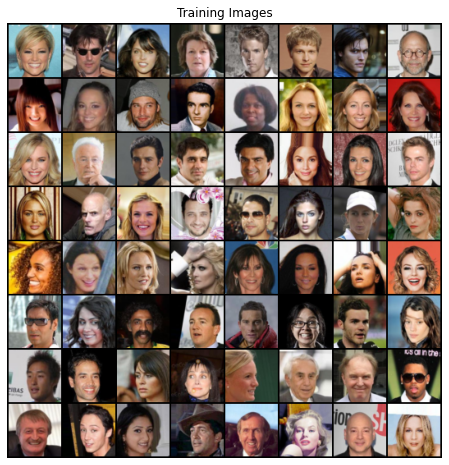

In [ ]:
#Step 1： Load dataset
#data root 
dataroot = 'data' 

#Create the dataset
dataset = datasets.ImageFolder(root = dataroot,
                               transform = transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                               ]))

#Load dataset #this line
workers = 2
batch_size = 64
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)#

#Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
#Step 2: Create model, setup loss function and optimizers
#Weight Initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Size of z latent vector (i.e. size of generator input)
latent_dim = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

#Network Architectures
#The following are the Discriminator and Generator architectures

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)



In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
#Create model #this line
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
G.apply(weights_init)
D.apply(weights_init)

#print the model
print(G, D)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
) 

In [ ]:
#Loss functions and optimizers
# Initialize cross entropy loss function
criterion = nn.BCELoss()

## Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both Generator and Discriminator
beta1 = 0.5
lr = 0.0002
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
#Step 3: Train the Discriminator and Generator

## Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

#use lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

#for each epoch
epochs = 10
for epoch in range(epochs):
    #for each batch in the dataloader
    for i, (inputs, labels) in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        inputs = inputs.to(device)# [batch, chan, w, h]
        

        #get the batch_size
        b_size = inputs.size(0) # (batch)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device) #[batch]

        #forward pass real batch through D

        output = D(inputs).view(-1)# [batch, 1, 1, 1] --> # [batch]
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device) #[batch, latent_dim, 1, 1]

        # Generate fake image batch with G
        fake = G(noise)  # [batch, chan, w, h]

 
        label.fill_(fake_label)
 
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1) # [batch]

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network
        ###########################
        G.zero_grad()
        label.fill_(real_label) # [batch]
        output = D(fake).view(-1) # [batch]
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/32]	Loss_D: 0.1613	Loss_G: 11.3989	D(x): 0.9418	D(G(z)): 0.0001 / 0.0000
[1/10][0/32]	Loss_D: 0.0008	Loss_G: 36.0348	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[2/10][0/32]	Loss_D: 0.0201	Loss_G: 39.2456	D(x): 0.9850	D(G(z)): 0.0000 / 0.0000
[3/10][0/32]	Loss_D: 0.0003	Loss_G: 37.6869	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[4/10][0/32]	Loss_D: 0.0005	Loss_G: 37.1943	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[5/10][0/32]	Loss_D: 0.0642	Loss_G: 30.3656	D(x): 0.9658	D(G(z)): 0.0000 / 0.0000
[6/10][0/32]	Loss_D: 0.9329	Loss_G: 10.9613	D(x): 0.6526	D(G(z)): 0.0006 / 0.0002
[7/10][0/32]	Loss_D: 0.5970	Loss_G: 5.0388	D(x): 0.7338	D(G(z)): 0.0185 / 0.0207
[8/10][0/32]	Loss_D: 1.7285	Loss_G: 9.5058	D(x): 0.9312	D(G(z)): 0.7452 / 0.0003
[9/10][0/32]	Loss_D: 1.0616	Loss_G: 6.8758	D(x): 0.9393	D(G(z)): 0.5354 / 0.0031


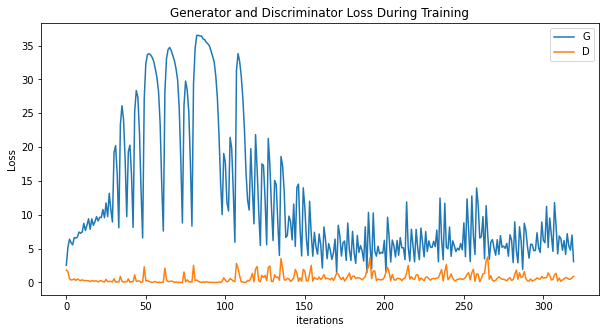

In [ ]:
#Generator and Discriminator Loss During Training
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

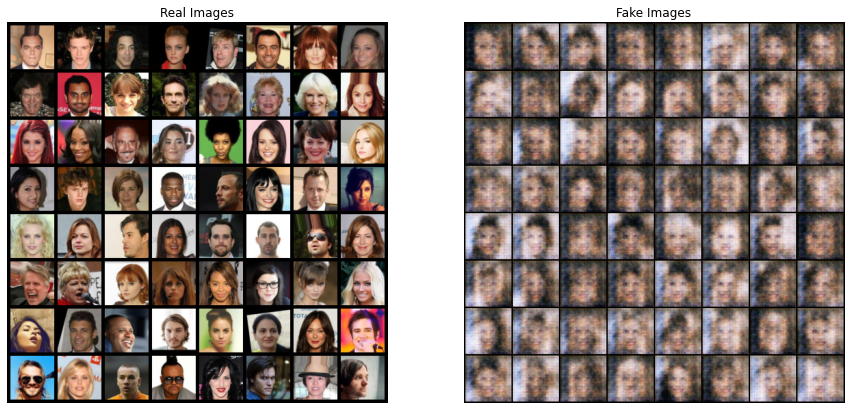

In [ ]:
#Real images vs. Fake images
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()